In [1]:
!pip install statsmodels


  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.5.0 requires torch>=2.0.0, which is not installed.
context-cite 0.0.4 requires torch, which is not installed.
context-cite 0.0.4 requires transformers, which is not installed.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
outlines 0.1.11 requires torch, which is not installed.
torchvision 0.21.0 requires torch==2.6.0, which is not installed.
vllm 0.8.5 requires tokenizers>=0.21.1, which is not installed.
vllm 0.8.5 requires torch==2.6.0, which is not installed.
vllm 0.8.5 requires transformers>=4.51.1, which is not installed.
xformers 0.0.29.post2 requires torch==2.6.0, which is not installed

In [2]:
import os
import pandas as pd

# Define input folder
input_folder = "Merge Attribution Scores 14B"

# Initialize list to collect statistics
stats_list = []

# Loop over all CSVs in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv") and filename.startswith("Merge_Q"):
        filepath = os.path.join(input_folder, filename)
        
        try:
            df = pd.read_csv(filepath)

            # Check if necessary columns exist
            if "Score" in df.columns and "Extracted_Answer" in df.columns:
                mean_score = df["Score"].mean()
                std_score = df["Score"].std()
                extracted_answer = df["Extracted_Answer"].dropna().astype(str).iloc[0] if not df["Extracted_Answer"].dropna().empty else None

                stats_list.append({
                    "QA_ID": filename.replace(".csv", ""),
                    "Mean_Score": mean_score,
                    "Std_Score": std_score,
                    "Extracted_Answer": extracted_answer
                })
            else:
                print(f"⚠️ Skipped {filename} (missing 'Score' or 'Extracted_Answer' column)")

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

# Create summary DataFrame
stats_df = pd.DataFrame(stats_list)

# Display the first few rows
stats_df.head(30)
print(len(stats_df))

4054


In [3]:
# Add new columns: 1 std above and below the mean
stats_df["Upper_Threshold"] = stats_df["Mean_Score"] + stats_df["Std_Score"]
stats_df["Lower_Threshold"] = stats_df["Mean_Score"] - stats_df["Std_Score"]

# Display updated DataFrame
stats_df.head()


,QA_ID,Mean_Score,Std_Score,Extracted_Answer,Upper_Threshold,Lower_Threshold
0,Merge_Q50,1.347768,5.552143,D,6.899911,-4.204376
1,Merge_Q1848,17.999883,46.132184,None,64.132067,-28.132300
2,Merge_Q2288,23.088897,48.500621,D,71.589519,-25.411724
3,Merge_Q3419,3.357434,NaN,B,NaN,NaN
4,Merge_Q2259,30.890691,30.010827,B,60.901519,0.879864


In [4]:
import os
import pandas as pd

# Initialize relevance columns with zero
stats_df["Highly Relevant"] = 0
stats_df["Low Relevant"] = 0
stats_df["Irrelevant"] = 0

# Define input directory
input_folder = "Merge Attribution Scores 14B"

# Process each QA file and compute relevance categories
for i, row in stats_df.iterrows():
    qa_id = row["QA_ID"]
    file_path = os.path.join(input_folder, f"{qa_id}.csv")

    try:
        df = pd.read_csv(file_path)

        if "Score" in df.columns:
            scores = df["Score"]

            # Count relevance categories based on thresholds
            high_count = (scores > row["Upper_Threshold"]).sum()
            low_count = ((scores >= row["Lower_Threshold"]) & (scores <= row["Upper_Threshold"]) & (scores != 0)).sum()
            zero_count = (scores == 0).sum()

            # Update stats_df with raw counts
            stats_df.at[i, "Highly Relevant"] = high_count
            stats_df.at[i, "Low Relevant"] = low_count
            stats_df.at[i, "Irrelevant"] = zero_count
        else:
            print(f"⚠️ Skipped {qa_id}.csv — 'Score' column not found.")

    except Exception as e:
        print(f"❌ Error processing {qa_id}.csv: {e}")

# Normalize counts into proportions
relevance_cols = ["Highly Relevant", "Low Relevant", "Irrelevant"]
relevance_totals = stats_df[relevance_cols].sum(axis=1)

for col in relevance_cols:
    stats_df[col] = stats_df[col] / relevance_totals

# Preview results
stats_df.head(500)


,QA_ID,Mean_Score,Std_Score,Extracted_Answer,Upper_Threshold,Lower_Threshold,Highly Relevant,Low Relevant,Irrelevant
0,Merge_Q50,1.347768,5.552143,D,6.899911,-4.204376,0.100000,0.900000,0.000000
1,Merge_Q1848,17.999883,46.132184,None,64.132067,-28.132300,0.125000,0.625000,0.250000
2,Merge_Q2288,23.088897,48.500621,D,71.589519,-25.411724,0.200000,0.800000,0.000000
3,Merge_Q3419,3.357434,NaN,B,NaN,NaN,NaN,NaN,NaN
4,Merge_Q2259,30.890691,30.010827,B,60.901519,0.879864,0.166667,0.833333,0.000000
...,...,...,...,...,...,...,...,...,...
495,Merge_Q1473,27.732020,25.529134,C,53.261153,2.202886,0.200000,0.800000,0.000000
496,Merge_Q1801,11.677990,18.711256,I,30.389245,-7.033266,0.111111,0.666667,0.222222
497,Merge_Q3747,2.404677,4.838246,D,7.242923,-2.433570,0.333333,0.666667,0.000000
498,Merge_Q2107,-0.964809,2.458583,F,1.493774,-3.423392,0.000000,1.000000,0.000000


## Measure Statistical Significance

In [5]:
# Reshape the DataFrame for analysis
df_long = stats_df[["Highly Relevant", "Low Relevant", "Irrelevant"]].reset_index().melt(
    id_vars="index", 
    var_name="RelevanceCategory", 
    value_name="Proportion"
)
df_long = df_long.rename(columns={"index": "Subject"})

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the repeated-measures ANOVA model
model = ols("Proportion ~ C(RelevanceCategory) + C(Subject)", data=df_long).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df_long["Proportion"],
                          groups=df_long["RelevanceCategory"],
                          alpha=0.05)
print(tukey)


/data/healthy-ml/scratch/yuexing/hf_env/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4053, but rank is 3955
  warnings.warn('covariance of constraints does not have full '


                            sum_sq      df             F  PR(>F)
C(RelevanceCategory)  7.579499e+02     2.0  8.779858e+03     0.0
C(Subject)            1.089101e-25  4053.0  6.225415e-28     1.0
Residual              3.414283e+02  7910.0           NaN     NaN
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
     group1        group2    meandiff p-adj lower upper reject
--------------------------------------------------------------
Highly Relevant   Irrelevant      nan   nan   nan   nan  False
Highly Relevant Low Relevant      nan   nan   nan   nan  False
     Irrelevant Low Relevant      nan   nan   nan   nan  False
--------------------------------------------------------------


In [6]:
std_score = stats_df["Mean_Score"].std()
print(f"Standard Deviation of Mean_Score: {std_score}")

mean_score=stats_df["Mean_Score"].mean()
print(f"Mean of Mean_Score: {mean_score}")


Standard Deviation of Mean_Score: 14.000088364833978
Mean of Mean_Score: 9.162228283102202


/tmp/ipykernel_2637115/800718107.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)


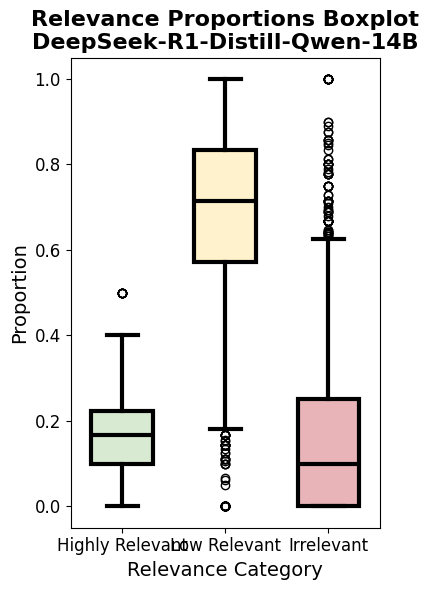

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Use your real stats_df here
# Example mock data:
# stats_df = pd.read_csv("your_data.csv")

# HEX colors sampled from your image
color_high = "#d9ead3"        # green for Highly Relevant
color_low = "#fff2cc"         # yellow for Low Relevant
color_irrel = "#e8b4b8"       # red-pink for Irrelevant

# Prepare data
data = [
    stats_df["Highly Relevant"].dropna(),
    stats_df["Low Relevant"].dropna(),
    stats_df["Irrelevant"].dropna()
]

labels = ["Highly Relevant", "Low Relevant", "Irrelevant"]
colors = [color_high, color_low, color_irrel]

# Create plot
fig, ax = plt.subplots(figsize=(4, 6))
bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)

# Set custom facecolors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_linewidth(3)

# Style other elements
for whisker in bp['whiskers']:
    whisker.set_linewidth(3)
for cap in bp['caps']:
    cap.set_linewidth(3)
for median in bp['medians']:
    median.set_linewidth(3)
    median.set_color("black")

# Labels and layout
ax.set_title("Relevance Proportions Boxplot\nDeepSeek-R1-Distill-Qwen-14B", fontsize=16, weight='bold')
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Relevance Category", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.savefig("qwen14b_relevance_boxplot_fixed.pdf", dpi=300)
plt.show()


/tmp/ipykernel_2637115/1551280758.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)
/tmp/ipykernel_2637115/1551280758.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)
/tmp/ipykernel_2637115/1551280758.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)
/tmp/ipykernel_2637115/1551280758.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; 

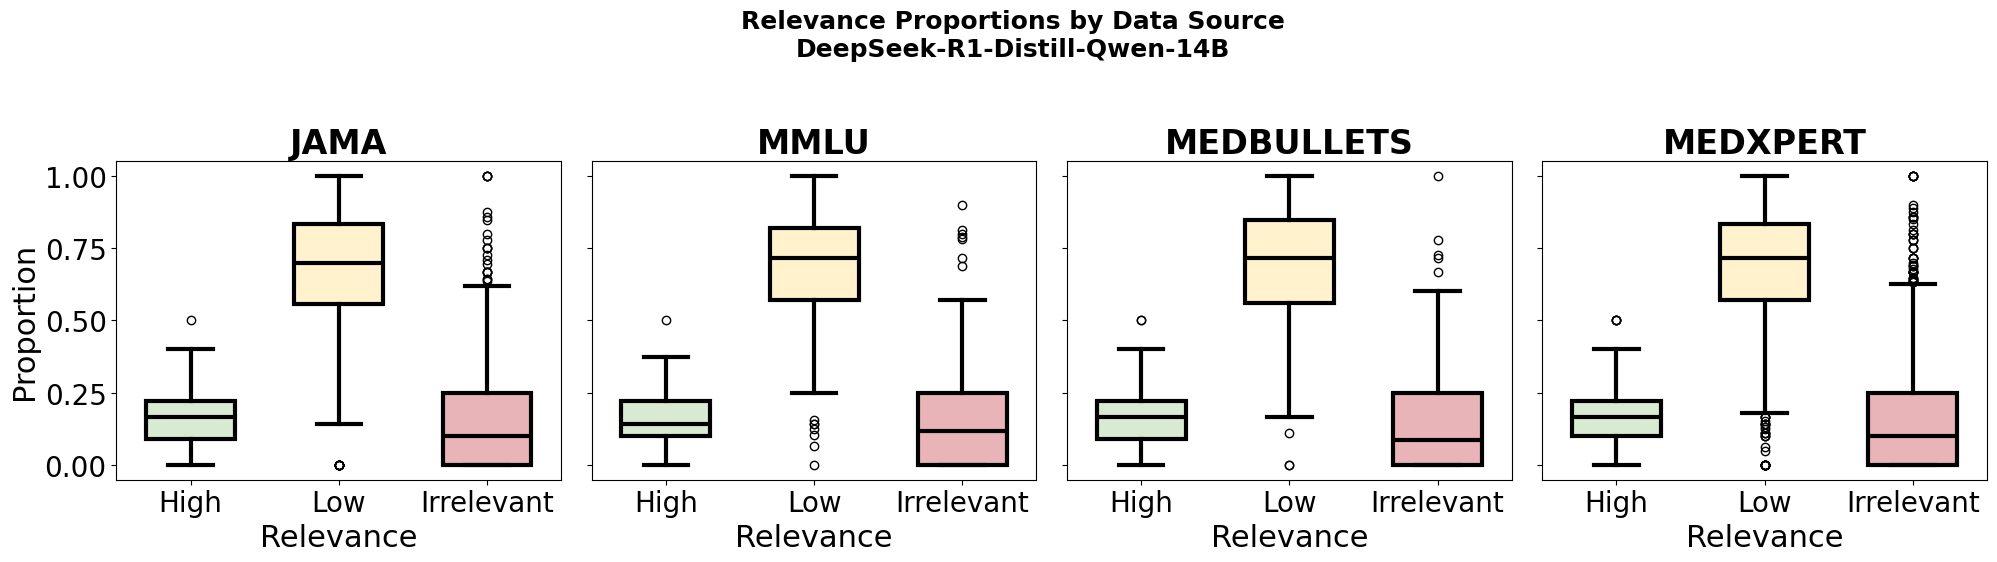

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Load ground truth
truth_df = pd.read_csv("merged_llm_4k_questions_with_QA_ID.csv")

# Align data_source column to stats_df
stats_df["data_source"] = truth_df.loc[stats_df.index, "data_source"].values

# Define colors and labels
color_high = "#d9ead3"    # green
color_low = "#fff2cc"     # yellow
color_irrel = "#e8b4b8"   # pink/red
colors = [color_high, color_low, color_irrel]
labels = ["High", "Low", "Irrelevant"]

# Define data sources and create a wide row of subplots
sources = ["jama", "mmlu", "medbullets", "medxpert"]
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

for i, source in enumerate(sources):
    ax = axes[i]
    subset = stats_df[stats_df["data_source"] == source]

    data = [
        subset["Highly Relevant"].dropna(),
        subset["Low Relevant"].dropna(),
        subset["Irrelevant"].dropna()
    ]

    bp = ax.boxplot(data, patch_artist=True, labels=labels, widths=0.6)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_linewidth(3)

    for whisker in bp['whiskers']:
        whisker.set_linewidth(3)
    for cap in bp['caps']:
        cap.set_linewidth(3)
    for median in bp['medians']:
        median.set_linewidth(3)
        median.set_color("black")

    ax.set_title(source.upper(), fontsize=24, weight='bold')
    ax.set_xlabel("Relevance", fontsize=22)
    ax.tick_params(axis='both', labelsize=20)

axes[0].set_ylabel("Proportion", fontsize=22)

# Final layout
plt.suptitle("Relevance Proportions by Data Source\nDeepSeek-R1-Distill-Qwen-14B", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.savefig("relevance_boxplot_4inrow.pdf", dpi=300)
plt.show()


In [11]:
import pandas as pd
import os

# Load the ground truth metadata
truth_df = pd.read_csv("merged_llm_4k_questions_with_QA_ID.csv")

# Folder containing the Merge_QXX.csv files
input_folder = "Merge Attribution Scores 14B"

# Loop through rows in truth_df and assign the corresponding data_source
for i in range(len(truth_df)):
    filename = f"Merge_Q{i+1}.csv"
    filepath = os.path.join(input_folder, filename)

    if os.path.exists(filepath):
        try:
            df = pd.read_csv(filepath)
            df["data_source"] = truth_df.loc[i, "data_source"]
            df.to_csv(filepath, index=False)
            print(f"✅ Updated {filename} with source: {truth_df.loc[i, 'data_source']}")
        except Exception as e:
            print(f"⚠️ Error reading/writing {filename}: {e}")
    else:
        print(f"❌ File not found: {filename}")


✅ Updated Merge_Q1.csv with source: jama
✅ Updated Merge_Q2.csv with source: jama
✅ Updated Merge_Q3.csv with source: jama
✅ Updated Merge_Q4.csv with source: jama
✅ Updated Merge_Q5.csv with source: jama
✅ Updated Merge_Q6.csv with source: jama
✅ Updated Merge_Q7.csv with source: jama
✅ Updated Merge_Q8.csv with source: jama
✅ Updated Merge_Q9.csv with source: jama
✅ Updated Merge_Q10.csv with source: jama
✅ Updated Merge_Q11.csv with source: jama
✅ Updated Merge_Q12.csv with source: jama
✅ Updated Merge_Q13.csv with source: jama
✅ Updated Merge_Q14.csv with source: jama
✅ Updated Merge_Q15.csv with source: jama
✅ Updated Merge_Q16.csv with source: jama
✅ Updated Merge_Q17.csv with source: jama
✅ Updated Merge_Q18.csv with source: jama
✅ Updated Merge_Q19.csv with source: jama
✅ Updated Merge_Q20.csv with source: jama
✅ Updated Merge_Q21.csv with source: jama
✅ Updated Merge_Q22.csv with source: jama
✅ Updated Merge_Q23.csv with source: jama
✅ Updated Merge_Q24.csv with source: jama
✅

✅ Updated Merge_Q203.csv with source: jama
✅ Updated Merge_Q204.csv with source: jama
✅ Updated Merge_Q205.csv with source: jama
✅ Updated Merge_Q206.csv with source: jama
✅ Updated Merge_Q207.csv with source: jama
✅ Updated Merge_Q208.csv with source: jama
✅ Updated Merge_Q209.csv with source: jama
✅ Updated Merge_Q210.csv with source: jama
✅ Updated Merge_Q211.csv with source: jama
✅ Updated Merge_Q212.csv with source: jama
✅ Updated Merge_Q213.csv with source: jama
✅ Updated Merge_Q214.csv with source: jama
✅ Updated Merge_Q215.csv with source: jama
✅ Updated Merge_Q216.csv with source: jama
✅ Updated Merge_Q217.csv with source: jama
✅ Updated Merge_Q218.csv with source: jama
✅ Updated Merge_Q219.csv with source: jama
✅ Updated Merge_Q220.csv with source: jama
✅ Updated Merge_Q221.csv with source: jama
✅ Updated Merge_Q222.csv with source: jama
✅ Updated Merge_Q223.csv with source: jama
✅ Updated Merge_Q224.csv with source: jama
✅ Updated Merge_Q225.csv with source: jama
✅ Updated M

✅ Updated Merge_Q406.csv with source: jama
✅ Updated Merge_Q407.csv with source: jama
✅ Updated Merge_Q408.csv with source: jama
✅ Updated Merge_Q409.csv with source: jama
✅ Updated Merge_Q410.csv with source: jama
✅ Updated Merge_Q411.csv with source: jama
✅ Updated Merge_Q412.csv with source: jama
✅ Updated Merge_Q413.csv with source: jama
✅ Updated Merge_Q414.csv with source: jama
✅ Updated Merge_Q415.csv with source: jama
✅ Updated Merge_Q416.csv with source: jama
✅ Updated Merge_Q417.csv with source: jama
✅ Updated Merge_Q418.csv with source: jama
✅ Updated Merge_Q419.csv with source: jama
✅ Updated Merge_Q420.csv with source: jama
✅ Updated Merge_Q421.csv with source: jama
✅ Updated Merge_Q422.csv with source: jama
✅ Updated Merge_Q423.csv with source: jama
✅ Updated Merge_Q424.csv with source: jama
✅ Updated Merge_Q425.csv with source: jama
✅ Updated Merge_Q426.csv with source: jama
✅ Updated Merge_Q427.csv with source: jama
✅ Updated Merge_Q428.csv with source: jama
✅ Updated M

✅ Updated Merge_Q612.csv with source: jama
✅ Updated Merge_Q613.csv with source: jama
✅ Updated Merge_Q614.csv with source: jama
✅ Updated Merge_Q615.csv with source: jama
✅ Updated Merge_Q616.csv with source: jama
✅ Updated Merge_Q617.csv with source: jama
✅ Updated Merge_Q618.csv with source: jama
✅ Updated Merge_Q619.csv with source: jama
✅ Updated Merge_Q620.csv with source: jama
✅ Updated Merge_Q621.csv with source: jama
✅ Updated Merge_Q622.csv with source: jama
✅ Updated Merge_Q623.csv with source: jama
✅ Updated Merge_Q624.csv with source: jama
✅ Updated Merge_Q625.csv with source: jama
✅ Updated Merge_Q626.csv with source: jama
✅ Updated Merge_Q627.csv with source: jama
✅ Updated Merge_Q628.csv with source: jama
✅ Updated Merge_Q629.csv with source: jama
✅ Updated Merge_Q630.csv with source: jama
✅ Updated Merge_Q631.csv with source: jama
✅ Updated Merge_Q632.csv with source: jama
✅ Updated Merge_Q633.csv with source: jama
✅ Updated Merge_Q634.csv with source: jama
✅ Updated M

✅ Updated Merge_Q812.csv with source: jama
✅ Updated Merge_Q813.csv with source: jama
✅ Updated Merge_Q814.csv with source: jama
✅ Updated Merge_Q815.csv with source: jama
✅ Updated Merge_Q816.csv with source: jama
✅ Updated Merge_Q817.csv with source: jama
✅ Updated Merge_Q818.csv with source: jama
✅ Updated Merge_Q819.csv with source: jama
✅ Updated Merge_Q820.csv with source: jama
✅ Updated Merge_Q821.csv with source: jama
✅ Updated Merge_Q822.csv with source: jama
✅ Updated Merge_Q823.csv with source: jama
✅ Updated Merge_Q824.csv with source: jama
✅ Updated Merge_Q825.csv with source: jama
✅ Updated Merge_Q826.csv with source: jama
✅ Updated Merge_Q827.csv with source: jama
✅ Updated Merge_Q828.csv with source: jama
✅ Updated Merge_Q829.csv with source: jama
✅ Updated Merge_Q830.csv with source: jama
✅ Updated Merge_Q831.csv with source: jama
✅ Updated Merge_Q832.csv with source: jama
✅ Updated Merge_Q833.csv with source: jama
✅ Updated Merge_Q834.csv with source: jama
✅ Updated M

✅ Updated Merge_Q1012.csv with source: jama
✅ Updated Merge_Q1013.csv with source: jama
✅ Updated Merge_Q1014.csv with source: jama
✅ Updated Merge_Q1015.csv with source: jama
✅ Updated Merge_Q1016.csv with source: jama
✅ Updated Merge_Q1017.csv with source: jama
✅ Updated Merge_Q1018.csv with source: jama
✅ Updated Merge_Q1019.csv with source: jama
✅ Updated Merge_Q1020.csv with source: jama
✅ Updated Merge_Q1021.csv with source: jama
✅ Updated Merge_Q1022.csv with source: jama
✅ Updated Merge_Q1023.csv with source: jama
✅ Updated Merge_Q1024.csv with source: jama
✅ Updated Merge_Q1025.csv with source: jama
✅ Updated Merge_Q1026.csv with source: jama
✅ Updated Merge_Q1027.csv with source: jama
✅ Updated Merge_Q1028.csv with source: jama
✅ Updated Merge_Q1029.csv with source: jama
✅ Updated Merge_Q1030.csv with source: jama
✅ Updated Merge_Q1031.csv with source: jama
✅ Updated Merge_Q1032.csv with source: jama
✅ Updated Merge_Q1033.csv with source: jama
✅ Updated Merge_Q1034.csv with s

✅ Updated Merge_Q1219.csv with source: medbullets
✅ Updated Merge_Q1220.csv with source: medbullets
✅ Updated Merge_Q1221.csv with source: medbullets
✅ Updated Merge_Q1222.csv with source: medbullets
✅ Updated Merge_Q1223.csv with source: medbullets
✅ Updated Merge_Q1224.csv with source: medbullets
✅ Updated Merge_Q1225.csv with source: medbullets
✅ Updated Merge_Q1226.csv with source: medbullets
✅ Updated Merge_Q1227.csv with source: medbullets
✅ Updated Merge_Q1228.csv with source: medbullets
✅ Updated Merge_Q1229.csv with source: medbullets
✅ Updated Merge_Q1230.csv with source: medbullets
✅ Updated Merge_Q1231.csv with source: medbullets
✅ Updated Merge_Q1232.csv with source: medbullets
✅ Updated Merge_Q1233.csv with source: medbullets
✅ Updated Merge_Q1234.csv with source: medbullets
✅ Updated Merge_Q1235.csv with source: medbullets
✅ Updated Merge_Q1236.csv with source: medbullets
✅ Updated Merge_Q1237.csv with source: medbullets
✅ Updated Merge_Q1238.csv with source: medbullets


✅ Updated Merge_Q1420.csv with source: medxpert
✅ Updated Merge_Q1421.csv with source: medxpert
✅ Updated Merge_Q1422.csv with source: medxpert
✅ Updated Merge_Q1423.csv with source: medxpert
✅ Updated Merge_Q1424.csv with source: medxpert
✅ Updated Merge_Q1425.csv with source: medxpert
✅ Updated Merge_Q1426.csv with source: medxpert
✅ Updated Merge_Q1427.csv with source: medxpert
✅ Updated Merge_Q1428.csv with source: medxpert
✅ Updated Merge_Q1429.csv with source: medxpert
✅ Updated Merge_Q1430.csv with source: medxpert
✅ Updated Merge_Q1431.csv with source: medxpert
✅ Updated Merge_Q1432.csv with source: medxpert
✅ Updated Merge_Q1433.csv with source: medxpert
✅ Updated Merge_Q1434.csv with source: medxpert
✅ Updated Merge_Q1435.csv with source: medxpert
✅ Updated Merge_Q1436.csv with source: medxpert
✅ Updated Merge_Q1437.csv with source: medxpert
✅ Updated Merge_Q1438.csv with source: medxpert
✅ Updated Merge_Q1439.csv with source: medxpert
✅ Updated Merge_Q1440.csv with source: m

✅ Updated Merge_Q1624.csv with source: medxpert
✅ Updated Merge_Q1625.csv with source: medxpert
✅ Updated Merge_Q1626.csv with source: medxpert
✅ Updated Merge_Q1627.csv with source: medxpert
✅ Updated Merge_Q1628.csv with source: medxpert
✅ Updated Merge_Q1629.csv with source: medxpert
✅ Updated Merge_Q1630.csv with source: medxpert
✅ Updated Merge_Q1631.csv with source: medxpert
✅ Updated Merge_Q1632.csv with source: medxpert
✅ Updated Merge_Q1633.csv with source: medxpert
✅ Updated Merge_Q1634.csv with source: medxpert
✅ Updated Merge_Q1635.csv with source: medxpert
✅ Updated Merge_Q1636.csv with source: medxpert
✅ Updated Merge_Q1637.csv with source: medxpert
✅ Updated Merge_Q1638.csv with source: medxpert
✅ Updated Merge_Q1639.csv with source: medxpert
✅ Updated Merge_Q1640.csv with source: medxpert
✅ Updated Merge_Q1641.csv with source: medxpert
✅ Updated Merge_Q1642.csv with source: medxpert
✅ Updated Merge_Q1643.csv with source: medxpert
✅ Updated Merge_Q1644.csv with source: m

✅ Updated Merge_Q1821.csv with source: medxpert
✅ Updated Merge_Q1822.csv with source: medxpert
✅ Updated Merge_Q1823.csv with source: medxpert
✅ Updated Merge_Q1824.csv with source: medxpert
✅ Updated Merge_Q1825.csv with source: medxpert
✅ Updated Merge_Q1826.csv with source: medxpert
✅ Updated Merge_Q1827.csv with source: medxpert
✅ Updated Merge_Q1828.csv with source: medxpert
✅ Updated Merge_Q1829.csv with source: medxpert
✅ Updated Merge_Q1830.csv with source: medxpert
✅ Updated Merge_Q1831.csv with source: medxpert
✅ Updated Merge_Q1832.csv with source: medxpert
✅ Updated Merge_Q1833.csv with source: medxpert
✅ Updated Merge_Q1834.csv with source: medxpert
✅ Updated Merge_Q1835.csv with source: medxpert
✅ Updated Merge_Q1836.csv with source: medxpert
✅ Updated Merge_Q1837.csv with source: medxpert
✅ Updated Merge_Q1838.csv with source: medxpert
✅ Updated Merge_Q1839.csv with source: medxpert
✅ Updated Merge_Q1840.csv with source: medxpert
✅ Updated Merge_Q1841.csv with source: m

✅ Updated Merge_Q2008.csv with source: medxpert
✅ Updated Merge_Q2009.csv with source: medxpert
✅ Updated Merge_Q2010.csv with source: medxpert
✅ Updated Merge_Q2011.csv with source: medxpert
✅ Updated Merge_Q2012.csv with source: medxpert
✅ Updated Merge_Q2013.csv with source: medxpert
✅ Updated Merge_Q2014.csv with source: medxpert
✅ Updated Merge_Q2015.csv with source: medxpert
✅ Updated Merge_Q2016.csv with source: medxpert
✅ Updated Merge_Q2017.csv with source: medxpert
✅ Updated Merge_Q2018.csv with source: medxpert
✅ Updated Merge_Q2019.csv with source: medxpert
✅ Updated Merge_Q2020.csv with source: medxpert
✅ Updated Merge_Q2021.csv with source: medxpert
✅ Updated Merge_Q2022.csv with source: medxpert
✅ Updated Merge_Q2023.csv with source: medxpert
✅ Updated Merge_Q2024.csv with source: medxpert
✅ Updated Merge_Q2025.csv with source: medxpert
✅ Updated Merge_Q2026.csv with source: medxpert
✅ Updated Merge_Q2027.csv with source: medxpert
✅ Updated Merge_Q2028.csv with source: m

✅ Updated Merge_Q2218.csv with source: medxpert
✅ Updated Merge_Q2219.csv with source: medxpert
✅ Updated Merge_Q2220.csv with source: medxpert
✅ Updated Merge_Q2221.csv with source: medxpert
✅ Updated Merge_Q2222.csv with source: medxpert
✅ Updated Merge_Q2223.csv with source: medxpert
✅ Updated Merge_Q2224.csv with source: medxpert
✅ Updated Merge_Q2225.csv with source: medxpert
✅ Updated Merge_Q2226.csv with source: medxpert
✅ Updated Merge_Q2227.csv with source: medxpert
✅ Updated Merge_Q2228.csv with source: medxpert
✅ Updated Merge_Q2229.csv with source: medxpert
✅ Updated Merge_Q2230.csv with source: medxpert
✅ Updated Merge_Q2231.csv with source: medxpert
✅ Updated Merge_Q2232.csv with source: medxpert
✅ Updated Merge_Q2233.csv with source: medxpert
✅ Updated Merge_Q2234.csv with source: medxpert
✅ Updated Merge_Q2235.csv with source: medxpert
✅ Updated Merge_Q2236.csv with source: medxpert
✅ Updated Merge_Q2237.csv with source: medxpert
✅ Updated Merge_Q2238.csv with source: m

✅ Updated Merge_Q2427.csv with source: medxpert
✅ Updated Merge_Q2428.csv with source: medxpert
✅ Updated Merge_Q2429.csv with source: medxpert
✅ Updated Merge_Q2430.csv with source: medxpert
✅ Updated Merge_Q2431.csv with source: medxpert
✅ Updated Merge_Q2432.csv with source: medxpert
✅ Updated Merge_Q2433.csv with source: medxpert
✅ Updated Merge_Q2434.csv with source: medxpert
✅ Updated Merge_Q2435.csv with source: medxpert
✅ Updated Merge_Q2436.csv with source: medxpert
✅ Updated Merge_Q2437.csv with source: medxpert
✅ Updated Merge_Q2438.csv with source: medxpert
✅ Updated Merge_Q2439.csv with source: medxpert
✅ Updated Merge_Q2440.csv with source: medxpert
✅ Updated Merge_Q2441.csv with source: medxpert
✅ Updated Merge_Q2442.csv with source: medxpert
✅ Updated Merge_Q2443.csv with source: medxpert
✅ Updated Merge_Q2444.csv with source: medxpert
✅ Updated Merge_Q2445.csv with source: medxpert
✅ Updated Merge_Q2446.csv with source: medxpert
✅ Updated Merge_Q2447.csv with source: m

✅ Updated Merge_Q2622.csv with source: medxpert
✅ Updated Merge_Q2623.csv with source: medxpert
✅ Updated Merge_Q2624.csv with source: medxpert
✅ Updated Merge_Q2625.csv with source: medxpert
✅ Updated Merge_Q2626.csv with source: medxpert
✅ Updated Merge_Q2627.csv with source: medxpert
✅ Updated Merge_Q2628.csv with source: medxpert
✅ Updated Merge_Q2629.csv with source: medxpert
✅ Updated Merge_Q2630.csv with source: medxpert
✅ Updated Merge_Q2631.csv with source: medxpert
✅ Updated Merge_Q2632.csv with source: medxpert
✅ Updated Merge_Q2633.csv with source: medxpert
✅ Updated Merge_Q2634.csv with source: medxpert
✅ Updated Merge_Q2635.csv with source: medxpert
✅ Updated Merge_Q2636.csv with source: medxpert
✅ Updated Merge_Q2637.csv with source: medxpert
✅ Updated Merge_Q2638.csv with source: medxpert
✅ Updated Merge_Q2639.csv with source: medxpert
✅ Updated Merge_Q2640.csv with source: medxpert
✅ Updated Merge_Q2641.csv with source: medxpert
✅ Updated Merge_Q2642.csv with source: m

❌ File not found: Merge_Q3356.csv
❌ File not found: Merge_Q3357.csv
❌ File not found: Merge_Q3358.csv
❌ File not found: Merge_Q3359.csv
❌ File not found: Merge_Q3360.csv
❌ File not found: Merge_Q3361.csv
❌ File not found: Merge_Q3362.csv
❌ File not found: Merge_Q3363.csv
❌ File not found: Merge_Q3364.csv
❌ File not found: Merge_Q3365.csv
❌ File not found: Merge_Q3366.csv
❌ File not found: Merge_Q3367.csv
❌ File not found: Merge_Q3368.csv
❌ File not found: Merge_Q3369.csv
❌ File not found: Merge_Q3370.csv
❌ File not found: Merge_Q3371.csv
❌ File not found: Merge_Q3372.csv
❌ File not found: Merge_Q3373.csv
❌ File not found: Merge_Q3374.csv
❌ File not found: Merge_Q3375.csv
❌ File not found: Merge_Q3376.csv
❌ File not found: Merge_Q3377.csv
❌ File not found: Merge_Q3378.csv
❌ File not found: Merge_Q3379.csv
❌ File not found: Merge_Q3380.csv
❌ File not found: Merge_Q3381.csv
❌ File not found: Merge_Q3382.csv
❌ File not found: Merge_Q3383.csv
❌ File not found: Merge_Q3384.csv
❌ File not fou

## Compare the Results

In [16]:
import pandas as pd

# Load the medbullets ground truth file
# truth_df = pd.read_csv("merged_llm_4k_questions.csv")

# Standardize formats
truth_df["answer_idx"] = truth_df["answer"].astype(str).str.strip().str.upper()
stats_df["Extracted_Answer"] = stats_df["Extracted_Answer"].astype(str).str.strip().str.upper()

# Extract numeric index from QA_ID
stats_df["QA_Index"] = stats_df["QA_ID"].str.extract(r"Q(\d+)", expand=False).astype(int) - 1  # 0-based indexing

# Map ground truth answers and data source
stats_df["Ground_Truth_Answer"] = stats_df["QA_Index"].map(truth_df["answer_idx"])
stats_df["Data_Source"] = stats_df["QA_Index"].map(truth_df["data_source"])

# Mark match status
stats_df["Answer_Match"] = stats_df["Extracted_Answer"] == stats_df["Ground_Truth_Answer"]

# Exclude rows where Extracted_Answer is "NONE"
valid_mask = stats_df["Extracted_Answer"].str.upper() != "NONE"
valid_answers = stats_df[valid_mask]

# Initialize containers
results = []

# Loop over each data source separately
for source in stats_df["Data_Source"].unique():
    source_mask = stats_df["Data_Source"] == source
    source_valid = stats_df[source_mask & valid_mask]
    
    # Compute accuracy and standard deviation
    source_accuracy = (source_valid["Extracted_Answer"] == source_valid["Ground_Truth_Answer"]).mean()
    source_std = (source_valid["Extracted_Answer"] == source_valid["Ground_Truth_Answer"]).std()
    source_excluded = source_mask.sum() - source_valid.shape[0]

    results.append({
        "Data_Source": source,
        "Accuracy": source_accuracy,
        "Std_Dev": source_std,
        "Excluded_Count": source_excluded,
        "Total_Cases": source_mask.sum()
    })

# Create a results DataFrame
results_df = pd.DataFrame(results)

# Calculate overall accuracy and standard deviation
overall_accuracy = valid_answers["Answer_Match"].mean()
overall_std = valid_answers["Answer_Match"].std()

# Append the overall stats
overall_row = pd.DataFrame({
    "Data_Source": ["Overall"],
    "Accuracy": [overall_accuracy],
    "Std_Dev": [overall_std],
    "Excluded_Count": [stats_df.shape[0] - valid_answers.shape[0]],
    "Total_Cases": [stats_df.shape[0]]
})

# Concatenate the overall row
results_df = pd.concat([results_df, overall_row], ignore_index=True)

# Display the results
print(results_df)

  Data_Source  Accuracy   Std_Dev  Excluded_Count  Total_Cases
0        jama  0.452683  0.497999               9         1034
1    medxpert  0.120329  0.325412              15         2450
2  medbullets  0.409396  0.492550               0          298
3        mmlu  0.669118  0.471398               0          272
4     Overall  0.263275  0.440465              24         4054


In [20]:
import pandas as pd
import os

# Load the ground truth metadata
truth_df = pd.read_csv("merged_llm_4k_questions_with_QA_ID.csv")

# Folder containing the Merge_QXX.csv files
input_folder = "Merge Attribution Scores 14B"

# Initialize a list to collect data from each file
all_data = []

# # Loop through rows in truth_df and read corresponding data with added data_source
# for i in range(len(truth_df)):
#     filename = f"Merge_Q{i+1}.csv"
#     filepath = os.path.join(input_folder, filename)

#     if os.path.exists(filepath):
#         try:
#             df = pd.read_csv(filepath)
#             df["data_source"] = truth_df.loc[i, "data_source"]
#             all_data.append(df)
#             print(f"✅ Loaded {filename} with source: {truth_df.loc[i, 'data_source']}")
#         except Exception as e:
#             print(f"⚠️ Error reading/writing {filename}: {e}")
#     else:
#         print(f"❌ File not found: {filename}")

# Concatenate all data into a single DataFrame
combined_df = pd.concat(all_data, ignore_index=True)

# Calculate mean and std for each category
summary_stats = combined_df.groupby("data_source")["Mean_Score"].agg(['mean', 'std']).reset_index()
summary_stats.rename(columns={'mean': 'Mean_Score', 'std': 'Std_Dev'}, inplace=True)

# Display the final summary
print(summary_stats)


ValueError: No objects to concatenate

In [14]:
stats_df_sorted.to_csv("Qwen_14B Results.csv", index=False)

NameError: name 'stats_df_sorted' is not defined